# Project 2 Part 1 
# <span style="color:darkred"> Dataset 1 : Median Resale Prices For Registered Applications by Town and Flat Type</span>

In [18]:
import numpy as np
import pandas as pd
import bokeh 
import os


##Read csv file into dataframe
fname1=(os.path.abspath('median-resale-prices-for-registered-applications-by-town-and-flat-type.csv'))

main_df1=pd.read_csv(fname1,sep=',',na_values=['na','-'])

print('***Median Resale Prices for Registered Applications by Town and Flat-Type ***\n') 

print('Number of rows in this dataset is {}'.format(main_df1.shape[0]))
print('Number of columns in this dataset is {}'.format(main_df1.shape[1]))

main_df1.head(5)

***Median Resale Prices for Registered Applications by Town and Flat-Type ***

Number of rows in this dataset is 7176
Number of columns in this dataset is 4


,quarter,town,flat_type,price
0,2007-Q2,Ang Mo Kio,1-room,NaN
1,2007-Q2,Ang Mo Kio,2-room,NaN
2,2007-Q2,Ang Mo Kio,3-room,172000.0
3,2007-Q2,Ang Mo Kio,4-room,260000.0
4,2007-Q2,Ang Mo Kio,5-room,372000.0


In [19]:
main_df1['year']= main_df1.quarter.str.slice(0,4)

#Calculate mean excluding NAN values and store into sub_df1
sub_df1=main_df1.groupby(['flat_type','town','year']).mean()

#reshape dataframe 
sub_df1=sub_df1.unstack(level=[2])

#Fill all NA value with 0
sub_df1.fillna(0.0, inplace = True)

In [20]:
#Get the DataFrame index level 0 (flat-types)
df1_idx_level_0= sub_df1.index.levels[0].tolist()

#Get the DataFrame columns level 1 (years)
df1_col_level_1=sub_df1.columns.levels[1].tolist()

#Get the list of columns(multi-indexed)
columns_list = sub_df1.columns

#Flatten the index by joining the 2 column index
ind = pd.Index([e[0] + e[1] for e in columns_list.tolist()])

#Rename the columns
sub_df1.columns=ind

for i,n in enumerate(sub_df1.columns):
    sub_df1.rename(columns={n:n[-4:]}, inplace = True)

#Find the maximum and the minimum average median resale price in the DataFrame
getmaxprice = sub_df1.max(axis=1).max()
getminprice = sub_df1.min(axis=1).min()


In [21]:
# Available town list
subdf1_ind=sub_df1.index
available_towns=list(subdf1_ind.get_level_values('town').unique())

In [22]:
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import dodge
from bokeh.models.widgets import RadioGroup
from bokeh.layouts import row,column,layout,widgetbox

output_notebook()

def refresh_doc(doc):
    def create_dataset(flat_type_info,default_year_1,default_year_2):
        #Subset to the datafrane
        price_df = sub_df1.loc[flat_type_info]
        #Reset index of price df
        price_df = price_df.reset_index()
        #Sort df according to min to max values
        price_df.sort_values(by=default_year_1,ascending=True,inplace= True,na_position='first')
        
        #Create a new df base on the sorted price df
        test_df=pd.DataFrame({'town':price_df['town'],'year_1':price_df[default_year_1],'year_2':price_df[default_year_2]})
        test_df['percent_change']=(price_df[default_year_2]-price_df[default_year_1])/price_df[default_year_1]*100
        test_df['name_year1']=default_year_1
        test_df['name_year2']=default_year_2
        
        return ColumnDataSource(test_df)
  
    def Hbarchart(src):
    
        source = src
        
        #Plot figure
        p = figure(y_range=source.data['town'], x_range=(0, getmaxprice+50000), plot_height=800, plot_width=800, 
                   title="Barchart of Average Median Resale Price for Selected Year 1 vs Selected Year 2",
                   toolbar_location=None, tools="")

        p.hbar(y=dodge('town', -0.15, range=p.y_range), right=src.column_names[2] , height=0.2, source=source,
               color="#00008b", legend='name_year1')

        p.hbar(y=dodge('town',  0.15, range=p.y_range), right=src.column_names[3] , height=0.2, source=source,
               color="#87cefa", legend='name_year2')

        # Hover tool with hline mode
        hover = HoverTool(tooltips=[('Town', '@town'),
                                    ('Median1', '@year_1'),
                                    ('Median2', '@year_2'),
                                    ('% Change', '@percent_change')],
                          mode='hline')
        # display a tooltip whenever the cursor is horizontally in line with a glyph

        p.add_tools(hover)

        p.y_range.range_padding = 0.1
        p.ygrid.grid_line_color = None
        p.yaxis.axis_label = 'Towns'
        p.xaxis.axis_label = 'Average Median Prices'
        p.legend.location = "top_right"
        p.legend.orientation = "vertical"
        
        return (p)


    def update(attr,old,new):
        # Get the room data for the graph
        flat_type_to_plot = room_selection.labels[room_selection.active]
        year_1_to_plot = year_1_selection.labels[year_1_selection.active]
        year_2_to_plot = year_2_selection.labels[year_2_selection.active]
           
        # Make a new dataset based on the selected # of rooms and years to plot
        new_src = create_dataset(flat_type_to_plot,year_1_to_plot,year_2_to_plot)

        # Update the source used to plot
        src.data.update(new_src.data)

    #Create radio buttons for room type / flat type selection
    room_selection = RadioGroup(labels=df1_idx_level_0, active=3)
    room_selection.on_change('active', update)
    default_room_type = room_selection.labels[room_selection.active]
    room_control = widgetbox(room_selection)

    #Create radio buttons for first year selection
    year_1_selection = RadioGroup(labels=df1_col_level_1, active=6)
    year_1_selection.on_change('active', update)
    default_year_1 = year_1_selection.labels[year_1_selection.active]
    year_1_control = widgetbox(year_1_selection)

    #Create radio buttons for second year selection
    year_2_selection = RadioGroup(labels=df1_col_level_1, active=10)
    year_2_selection.on_change('active', update)
    default_year_2 = year_2_selection.labels[year_2_selection.active]
    year_2_control = widgetbox(year_2_selection)
    
    src = create_dataset(default_room_type,default_year_1,default_year_2)
    
    plot = Hbarchart(src)

    l= layout([
        [room_control,year_1_control,year_2_control],
        [plot]])
    
    doc.add_root(l)

Loading BokehJS ...

In [23]:
show(refresh_doc)

In [24]:
from bokeh.core.properties import value
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.transform import dodge
from bokeh.models.widgets import RadioGroup, CheckboxGroup
from bokeh.layouts import row,column,layout,widgetbox

output_notebook()

def refresh_doc(doc):
    def create_dataset(room_type_info,town_list):
        #Subset to the dataframe - filter by room type
        price_df = sub_df1.loc[room_type_info]
        #Reshape the dataframe 
        test_df1=price_df.stack()
        test_df1=test_df1.unstack(0)
        #Create a new df price_by_town
        price_by_town=pd.DataFrame()
        list_of_towns=[]
        for town_name in town_list:
            #Iterate through town list
            test_df1a=test_df1.loc[:,town_name]
            # Add to the overall dataframe
            price_by_town = pd.concat([price_by_town,test_df1a], axis=1, ignore_index=False, sort=False)
            list_of_towns.append([town_name])
        
        #Customize my line color
        MyCustomColor=['#00008B','#0000FF','#7B68EE', '#6495ED','#00BFFF','#BFBFE2','#B0C4DE','#5F9EA0','#40E0D0','#7FFFD4',
                       '#008080','#008000','#00FA9A','#FFA07A','#FF6347','#FF8C00','#A0522D','#D2691E','#DAA520','#F4A460',
                       '#BC8F8F','#D2B48C','#FFA07A','#FF0000','#DC143C','#C71585']
        
        #Create x points for plotting 
        numline = len(price_by_town.columns)
        xs=[[i for i in price_by_town.index][:]]*(numline)
        #Create y points for plotting
        ys=[]
        mylinecolour=[]
        for ind,ele in enumerate(price_by_town.columns):
            ys.append(price_by_town[ele].values.tolist())
            mylinecolour.append([MyCustomColor[ind]])
        
        return ColumnDataSource(dict(xs=xs,ys=ys,label=list_of_towns,colour=mylinecolour))
    
    
    def Line_plot(src):
        
        source = src

        p = figure(y_range=(getminprice, getmaxprice+50000), x_range=(2007,2018), plot_height=800, plot_width=800, 
                   title="Line Chart of Average Median Resale Price for Selected Towns",
                   toolbar_location=None, tools="")
        
        p.xaxis.ticker = list(range(2007,2019))
        #Plot multi line plot
        p.multi_line(xs='xs', ys='ys', source=source, line_width=3, color='colour', legend = 'label')
        
        # Hover tool with vline mode
        #hover = HoverTool(tooltips=[('ys', '@ys')],mode='vline')

        #p.add_tools(hover)
        
        p.legend.location = "top_right"
        p.legend.orientation = "vertical"
        p.legend.click_policy = 'hide'

        return (p)
    
    def update(attr,old,new):
        
        # Get the room data for the plot
        flat_type_to_plot = room_selection.labels[room_selection.active]
        # Get the town data for the plot
        town_list = [town_selection.labels[i] for i in town_selection.active]
        
        # Make a new dataset based on the selected # of rooms and town
        new_src = create_dataset(flat_type_to_plot, town_list)
        # Update the data for plot 
        src.data.update(new_src.data)

    #Make Radio buttons for room type selection
    room_selection = RadioGroup(labels=df1_idx_level_0, active=3)
    room_selection.on_change('active', update)
    default_room_type = room_selection.labels[room_selection.active]
    room_control = widgetbox(room_selection)
    
    #Make CheckBoxes for Town selection
    town_selection = CheckboxGroup(labels=available_towns, active = [0,1,2,4])
    town_selection.on_change('active', update)
    default_town = [town_selection.labels[i] for i in town_selection.active]
    town_control = widgetbox(town_selection)

    src = create_dataset(default_room_type,default_town)
    
    plot = Line_plot(src)

    #Design the layout of the plot
    l= layout([
        [room_control,town_control],
        [plot]])  
    
    doc.add_root(l)

Loading BokehJS ...

In [25]:
show(refresh_doc)

# <span style="color:darkred"> Dataset 2 : Resale Flat Prices Based On Registration Date </span>

In [29]:
import pandas as pd
import os

##Read csv file into dataframe
fname2a=(os.path.abspath('resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv'))
fname2b=(os.path.abspath('resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv'))

main_df2a = pd.read_csv(fname2a,sep=',',na_values=['na','-'])
main_df2b = pd.read_csv(fname2b,sep=',',na_values=['na','-'])

#convert month to datetime
main_df2a['month'] = pd.to_datetime(main_df2a['month'], format='%Y-%m').dt.year
main_df2b['month'] = pd.to_datetime(main_df2b['month'], format='%Y-%m').dt.year

#Create a column remaining lease = 99 - (year of registration-lease_commence_date) & insert it after column 'lease_commence_date'
remaining_lease_201214=99-(main_df2a['month']-main_df2a['lease_commence_date'])
main_df2a.insert(main_df2a.columns.get_loc('lease_commence_date') + 1, 'remaining_lease', remaining_lease_201214, allow_duplicates=False)

#append to the main df
main_df2=main_df2a.append(main_df2b, ignore_index=True)

print('*** Resale Flat Prices Based on Registration Date ***\n') 

print('Number of rows in this dataset is {}'.format(main_df2.shape[0]))
print('Number of columns in this dataset is {}'.format(main_df2.shape[1]))

#Preview 5 rows of data
main_df2.head(5)

*** Resale Flat Prices Based on Registration Date ***

Number of rows in this dataset is 131303
Number of columns in this dataset is 11


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2012,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,73,250000.0
1,2012,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,67,265000.0
2,2012,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,67,315000.0
3,2012,ANG MO KIO,3 ROOM,474,ANG MO KIO AVE 10,01 TO 05,67.0,New Generation,1984,71,320000.0
4,2012,ANG MO KIO,3 ROOM,604,ANG MO KIO AVE 5,06 TO 10,67.0,New Generation,1980,67,321000.0


In [30]:
#Filter the data into sub_df2a, drop unwanted columns
sub_df2a=main_df2.drop(['block','street_name','storey_range','flat_model','lease_commence_date'],axis=1)
#Rename column month to year
sub_df2a.rename(columns={'month':'year'},inplace = True)

#Create a column with calculated psm price and round it to 2 decimal places
sub_df2a['psm_price']=sub_df2a['resale_price']/sub_df2a['floor_area_sqm']
sub_df2a=sub_df2a.round({'psm_price':2})


#Create a dictionary to map town to respective region
town_to_region = { 'ANG MO KIO' : 'North East', 'BEDOK' : 'East', 'BISHAN' : 'Central', 'BUKIT BATOK': 'West',
                  'BUKIT MERAH' : 'Central', 'BUKIT PANJANG' : 'West', 'BUKIT TIMAH' : 'Central', 'CENTRAL AREA' : 'Central',
                  'CHOA CHU KANG' : 'West', 'CLEMENTI' : 'West', 'GEYLANG' : 'Central', 'HOUGANG' : 'North East', 
                  'JURONG EAST' : 'West', 'JURONG WEST' : 'West', 'KALLANG/WHAMPOA' : 'Central', 'MARINE PARADE' : 'Central',
                  'PASIR RIS' : 'East','PUNGGOL' : 'North East','QUEENSTOWN' : 'Central', 'SEMBAWANG' : 'North', 
                  'SENGKANG' : 'North East', 'SERANGOON' : 'North East', 'TAMPINES' : 'East', 'TOA PAYOH' : 'Central', 
                  'WOODLANDS' : 'North', 'YISHUN' : 'North'}

sub_df2a['region'] = sub_df2a['town'].map(town_to_region)

sub_df2a.set_index('flat_type', inplace = True)

#Subset dataframe by room type
Room_type = '4 ROOM'
room_df2a=sub_df2a.loc[Room_type]

#Filter to year selected and sort the data by region
year_selected = 2017
year_subset_df2a = room_df2a[room_df2a['year']==year_selected]
year_df2a_by_region = year_subset_df2a.sort_values(by=['region'])

# Create a list of available towns (unique values)
available_towns = list(sub_df2a['town'].unique())

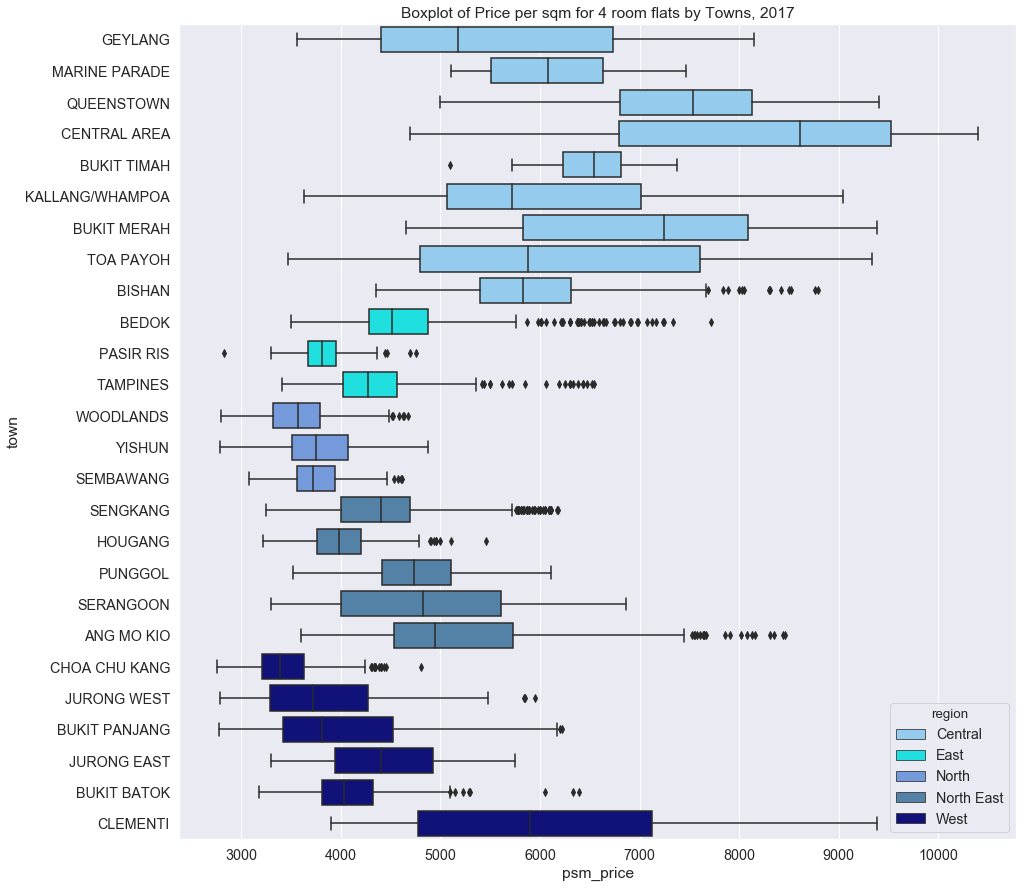

In [31]:
#Plot box plot with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
palette = {"Central":"#87CEFA","East":"#00FFFF","North":"#6495ED", "North East":"#4682B4", "West": "#00008B"}

fig, ax = plt.subplots(figsize=(15,15))

ax = sns.boxplot(x='psm_price', y='town', hue='region',data=year_df2a_by_region, dodge=False, palette= palette)
ax.set_title('Boxplot of Price per sqm for 4 room flats by Towns, 2017');

plt.show()


In [32]:
#Create a new column (hdb age) in dataframe
year_df2a_by_region['hdb age']= 99-year_df2a_by_region['remaining_lease']

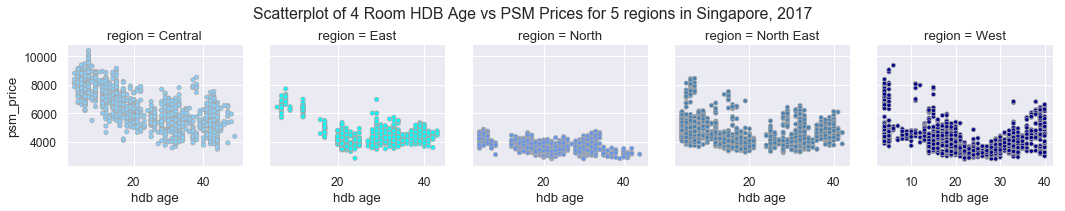

In [33]:
#Plot scatter plot of HDB age by region
sns.set(font_scale=1.1)  

palette = {"Central":"#87CEFA","East":"#00FFFF","North":"#6495ED", "North East":"#4682B4", "West": "#00008B"}
fig1=sns.FacetGrid(year_df2a_by_region, col= 'region', hue='region', sharex=False, sharey=True ,height = 3, aspect=1, palette=palette)
fig1=fig1.map(sns.scatterplot, 'hdb age', 'psm_price', size = 5, edgecolor = 'darkgrey')
plt.subplots_adjust(top=0.8)
fig1.fig.suptitle('Scatterplot of 4 Room HDB Age vs PSM Prices for 5 regions in Singapore, 2017')

plt.show()


In [34]:
import numpy as np
from bokeh.core.properties import value
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import dodge
from bokeh.models.widgets import CheckboxGroup, RangeSlider
from bokeh.layouts import row,column,layout,widgetbox

output_notebook()

def refresh_doc(doc):
    def create_dataset(town_list,year_start,year_end):
        #Subset to room type
        year_df2=room_df2a[(room_df2a['year'] >= year_start) & (room_df2a['year'] <= year_end )]
        #Get the starting and the ending range of the histogram
        range_start=year_df2['psm_price'].min()-500
        range_end=year_df2['psm_price'].max()+500
        range_extent= range_end-range_start
        #Create an empty histogram with the named columns
        dist_by_town = pd.DataFrame(columns=['count', 'left', 'right', 'name', 'color'])
        
        #Fix the bin width
        bin_width=200
        
        #Customize my line color
        MyCustomColor=['#00008B','#0000FF','#7B68EE', '#6495ED','#00BFFF','#BFBFE2','#B0C4DE','#5F9EA0','#40E0D0','#7FFFD4',
                       '#008080','#008000','#00FA9A','#FFA07A','#FF6347','#FF8C00','#A0522D','#D2691E','#DAA520','#F4A460',
                       '#BC8F8F','#D2B48C','#FFA07A','#FF0000','#DC143C','#C71585']
        
        # Iterate through all the towns
        for i, town_name in enumerate(town_list):
            #Create a new df with year df2 subset by town name
            test_df2=year_df2[(year_df2['town']==town_name)]

            test_df2.reset_index(inplace=True)
            test_df2.set_index(['flat_type','town'],inplace=True)

            # Create a histogram with bins = $200
            price_hist, edges = np.histogram(test_df2['psm_price'], bins = int(range_extent / bin_width), range = [range_start, range_end])
            price_df = pd.DataFrame({'count': price_hist, 'left': edges[:-1], 'right': edges[1:] })
        
            # Assign the town for labels
            price_df['name'] = town_name
        
            # Customize color for each town
            price_df['color']=MyCustomColor[i]

            # Append to the overall df
            dist_by_town = dist_by_town.append(price_df)

        return ColumnDataSource(dist_by_town)
  
    def Histogram_plot(src):
        #source = ColumnDataSource(data=dist_by_town)
        source = src
    
        p = figure(plot_width = 700, plot_height = 700, 
                      title = 'Histogram of per sqm prices by town',
                      x_axis_label = 'psm prices', y_axis_label = 'Count')

        # Quad glyphs to create a histogram
        p.quad(source = source, bottom = 0, top = 'count', left = 'left', right = 'right', color='color',
           fill_alpha = 0.7, legend = 'name', hover_fill_alpha = 1.0, line_color = 'black')

        # Hover tool with vline mode
        hover = HoverTool(tooltips=[('Town', '@name'), 
                                    ('Count', '@count')],
                          mode='vline')

        p.add_tools(hover)

        p.legend.click_policy = 'hide'
        return (p)

    def update(attr,old,new):
        # Get the town data for the plot
        town_list = [town_selection.labels[i] for i in town_selection.active]
        # Value for the range slider is a tuple (start, end)
        year_start = year_select.value[0]
        year_end = year_select.value[1]
           
        # Make a new dataset based on the selected town and year of distribution
        new_src = create_dataset(town_list,year_start,year_end)

        # Update the source used the quad glpyhs
        src.data.update(new_src.data)

    #Create the Check box buttons for town selection
    town_selection = CheckboxGroup(labels=available_towns, active = [0, 1])
    town_selection.on_change('active', update)

    #Create the year range slider for year range selection
    year_select = RangeSlider(start = 2012, end = 2018, value = (2012, 2018), step = 1, title = 'Year Range (year)')
    year_select.on_change('value', update)

    #Define default year selection and town selection to start the plot
    default_year_start=year_select.value[0]
    default_year_end=year_select.value[1]

    default_town = [town_selection.labels[i] for i in town_selection.active]

    src = create_dataset(default_town, year_start = default_year_start, year_end = default_year_end)
    
    #Plot the Histogram
    plot = Histogram_plot(src)

    # Put controls in a single widgetbox
    controls = widgetbox(town_selection, year_select)
    
    # Create a row layout
    layout = row(controls, plot)
    
    doc.add_root(layout)

Loading BokehJS ...

In [35]:
show(refresh_doc)